In [4]:
import numpy as np
import gpflow
from tqdm import tqdm
from gpflow.utilities import print_summary
import matplotlib.pyplot as plt

np.random.seed(42)
X = np.linspace(0, 150, 150).reshape(-1, 1)
Y = np.concatenate([np.zeros((50, 1)), np.ones((50, 1)), np.zeros((50, 1))]).reshape(-1, 1)
Y = 0.1 * np.random.randn(150).reshape(-1, 1) + Y
location = 75
steepness = 1.0

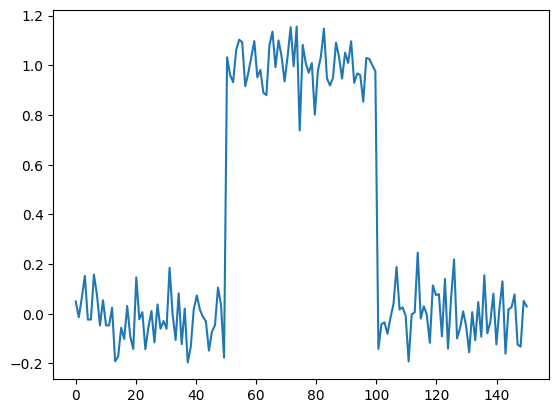

In [5]:
plt.plot(X, Y)

In [6]:
k1 = gpflow.kernels.Matern32()
k2 = gpflow.kernels.Matern32()


# 实例化变点核函数
changepoint_kernel = gpflow.kernels.ChangePoints([k1, k2], locations=[location], steepness=steepness)
gpr_model_base = gpflow.models.GPR(data=(X, Y), kernel=changepoint_kernel, mean_function=None)
opt = gpflow.optimizers.Scipy()
opt.minimize(gpr_model_base.training_loss, variables=gpr_model_base.trainable_variables)

nlml_C = gpr_model_base.training_loss().numpy()

kernel = gpflow.kernels.Matern32()
model = gpflow.models.GPR(data=(X, Y), kernel=kernel, mean_function=None)
optimizer = gpflow.optimizers.Scipy()
optimizer.minimize(model.training_loss, model.trainable_variables, options=dict(maxiter=100))

nlml_M = model.training_loss().numpy()

print(f"包含变点核函数的nlml: {nlml_C}")
print(f"不包含变点核函数的nlml: {nlml_M}")

v = 1 - 1 /(1 + np.exp(-(nlml_C - nlml_M)))
loc = changepoint_kernel.locations.numpy()[0]

print(f"变点得分：{v}")
print(loc)
print(f"变点位置：{loc / 150}")

包含变点核函数的nlml: -40.73692177247082
不包含变点核函数的nlml: -42.29784023927627
变点得分：0.173514892514542
74.00032912700816
变点位置：0.4933355275133877


In [ ]:
T = len(X)
t, t_1 = len(X), len(X)
lbw = 21
l_max, mu = 21, 0.9
l_max, mu = 63, 0.95
l_min = 5
R = []

kernel = gpflow.kernels.Matern32()
k1 = gpflow.kernels.Matern32()
k2 = gpflow.kernels.Matern32()

with tqdm(total=t) as pbar:
    while t >= 0:
        x = X[t - lbw : t]
        y = Y[t - lbw : t]
        location = int((2 * t - lbw) // 2)
        
        model = gpflow.models.GPR(data=(x, y), kernel=kernel, mean_function=None)
        optimizer = gpflow.optimizers.Scipy()
        optimizer.minimize(model.training_loss, model.trainable_variables, options=dict(maxiter=100))
        nlml_M = model.training_loss().numpy()
        
        changepoint_kernel = gpflow.kernels.ChangePoints([k1, k2], locations=[location], steepness=steepness)
        gpr_model_base = gpflow.models.GPR(data=(x, y), kernel=changepoint_kernel, mean_function=None)
        opt = gpflow.optimizers.Scipy()
        opt.minimize(gpr_model_base.training_loss, variables=gpr_model_base.trainable_variables)
        nlml_C = gpr_model_base.training_loss().numpy()
        
        loc = changepoint_kernel.locations.numpy()[0]
        loc = int(loc)
        L_C = np.exp(-nlml_C)
        L_M = np.exp(-nlml_M)
        v = L_C / (L_M + L_C)
        
        if v > mu:
            t_0 = loc
            if t_0 - loc >= l_min:
                R.append((t_0, t_1))
            t = loc - 1
            t_1 = t
        else:
            t = t - 1
            if t_1 - t > l_max:
                t = t_1 - l_max
            if t_1 - t == l_max:
                R.append((t, t_1))
        
        pbar.update(1)
        

In [12]:
loc

108.99999834011585

In [11]:
t

107.99999834011585